In [32]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

# EDA and Visualization

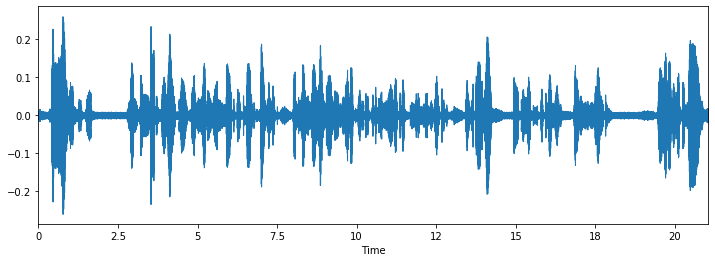

In [50]:
train_audio_path = "dataset/LibriSpeech/train-clean-100/103/1240/"
samples, sample_rate = librosa.load(train_audio_path + "103-1240-0029.flac")
plt.figure(figsize=(12, 4))
librosa.display.waveplot(samples, sr=16000)

In [51]:
ipd.Audio(samples, rate=sample_rate)

In [52]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

**duration of recoding**

In [75]:
import glob
path = train_audio_path + "*.flac"
voice = glob.glob(path)

(array([ 1.,  0.,  2.,  1.,  2.,  2.,  4.,  9., 27., 10.]),
 array([ 3.81002268,  5.11502041,  6.42001814,  7.72501587,  9.03001361,
        10.33501134, 11.64000907, 12.9450068 , 14.25000454, 15.55500227,
        16.86      ]),
 <a list of 10 Patch objects>)

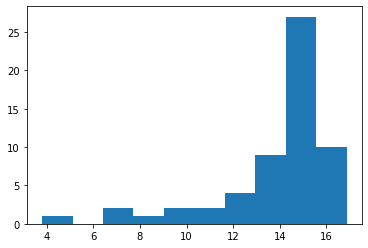

In [79]:
duration_of_recordings = []
for wav in voice:
        samples, sample_rate,  = librosa.load(wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))